In [ ]:
%pip install fastparquet
%pip uninstall dill -y
%pip install "dill==0.3.8"

In [1]:
# ============================================================================
# IMPORTS Y CONFIGURACIÓN INICIAL - DEBERTA-V3-BASE PARA POEM_SENTIMENT
# ============================================================================

# Instala dependencias avanzadas
#%pip install transformers torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#%pip install datasets accelerate peft
#%pip install scikit-learn numpy pandas matplotlib seaborn
#%pip install nltk fastparquet

# ============================================================================
# IMPORTS DE LIBRERÍAS
# ============================================================================

import os
import re
import random
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LinearLR

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, set_seed
)
from datasets import Dataset as HFDataset

import nltk
from nltk.corpus import stopwords

# Desactivar warnings molestos
warnings.filterwarnings("ignore")
set_seed(42)

# ============================================================================
# CONFIGURACIÓN GLOBAL
# ============================================================================

class Config:
    # Modelo
    MODEL_NAME = "microsoft/deberta-v3-base"
    MAX_LEN = 128
    NUM_LABELS = 3  # Excluyendo clase 3 (mixed)

    # Entrenamiento
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 6
    WARMUP_RATIO = 0.05
    WEIGHT_DECAY = 0.01

    # Regularización
    LABEL_SMOOTHING = 0.1
    FOCAL_GAMMA = 1.5
    R_DROP_ALPHA = 4.0

    # Validación
    N_FOLDS = 5
    EARLY_STOPPING_PATIENCE = 3

    # Paths
    OUTPUT_DIR = "./deberta_results"
    LOGGING_DIR = "./logs"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

print(f"Using device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")
print(f"Max length: {config.MAX_LEN}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")

# ============================================================================
# PREPROCESAMIENTO AVANZADO
# ============================================================================

def advanced_text_preprocessing(text: str) -> str:
    """
    Preprocesamiento avanzado para texto poético:
    - Eliminar duplicados de versos
    - Normalizar comillas y guiones
    - NO stemming/stopwords (preservar matices)
    """
    if not isinstance(text, str):
        return ""

    # Normalizar comillas (usando unicode characters)
    text = re.sub(r'[“”«»„"]', '"', text) # Double quotes
    text = re.sub(r'[‘’‹›`´]', "'", text) # Single quotes and backticks/accents

    # Normalizar guiones
    text = re.sub(r'[–—]', '-', text)

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)

    # Eliminar espacios al inicio/fin
    text = text.strip()

    return text

def remove_duplicate_verses(df: pd.DataFrame) -> pd.DataFrame:
    """Eliminar versos duplicados dentro del mismo dataset."""
    initial_len = len(df)
    df_clean = df.drop_duplicates(subset=['verse_text'], keep='first')
    final_len = len(df_clean)

    print(f"Removed {initial_len - final_len} duplicate verses")
    return df_clean

# ============================================================================
# FOCAL LOSS PARA DESBALANCE
# ============================================================================

class FocalLoss(nn.Module):
    """Focal Loss para manejar desbalance de clases."""
    def __init__(self, alpha=None, gamma=config.FOCAL_GAMMA, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# R-DROP REGULARIZATION
# ============================================================================

def r_drop_loss(logits1, logits2, targets, alpha=config.R_DROP_ALPHA):
    """R-Drop regularization para mejorar generalización."""
    loss1 = F.cross_entropy(logits1, targets, reduction='mean')
    loss2 = F.cross_entropy(logits2, targets, reduction='mean')

    # KL divergence entre las dos predicciones
    kl_loss = F.kl_div(
        F.log_softmax(logits1, dim=-1),
        F.softmax(logits2, dim=-1),
        reduction='batchmean'
    )

    return (loss1 + loss2) / 2 + alpha * kl_loss

# ============================================================================
# DATASET CUSTOM PARA HUGGINGFACE
# ============================================================================

class PoemSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=config.MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ============================================================================
# CUSTOM TRAINER CON FOCAL LOSS Y R-DROP
# ============================================================================

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, use_r_drop=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.use_r_drop = use_r_drop

        if class_weights is not None:
            self.criterion = FocalLoss(alpha=class_weights.to(self.model.device))
        else:
            self.criterion = FocalLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        if self.use_r_drop:
            # Forward pass 1
            outputs1 = model(**inputs)
            logits1 = outputs1.logits

            # Forward pass 2 (con dropout diferente)
            outputs2 = model(**inputs)
            logits2 = outputs2.logits

            # R-Drop loss
            loss = r_drop_loss(logits1, logits2, labels)
        else:
            # Forward pass normal
            outputs = model(**inputs)
            logits = outputs.logits
            loss = self.criterion(logits, labels)

        return (loss, outputs) if return_outputs else loss

# ============================================================================
# MÉTRICAS CUSTOM PARA F1 MACRO
# ============================================================================

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# ============================================================================
# VALIDACIÓN CON STRATIFIED K-FOLD
# ============================================================================

def stratified_kfold_training(train_texts, train_labels, config):
    """Entrenamiento con Stratified K-Fold para robustez."""

    # Configurar estratificación
    skf = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
        print(f"\n{'='*50}")
        print(f"FOLD {fold + 1}/{config.N_FOLDS}")
        print(f"{'='*50}")

        # Split data
        fold_train_texts = [train_texts[i] for i in train_idx]
        fold_train_labels = [train_labels[i] for i in train_idx]
        fold_val_texts = [train_texts[i] for i in val_idx]
        fold_val_labels = [train_labels[i] for i in val_idx]

        # Calcular class weights para este fold
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(fold_train_labels),
            y=fold_train_labels
        )
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Tokenizer y modelo
        tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        model = AutoModelForSequenceClassification.from_pretrained(
            config.MODEL_NAME,
            num_labels=config.NUM_LABELS,
            label_smoothing=config.LABEL_SMOOTHING
        )

        # Datasets
        train_dataset = PoemSentimentDataset(fold_train_texts, fold_train_labels, tokenizer)
        val_dataset = PoemSentimentDataset(fold_val_texts, fold_val_labels, tokenizer)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f"{config.OUTPUT_DIR}/fold_{fold}",
            logging_dir=f"{config.LOGGING_DIR}/fold_{fold}",
            num_train_epochs=config.NUM_EPOCHS,
            per_device_train_batch_size=config.BATCH_SIZE,
            per_device_eval_batch_size=config.BATCH_SIZE * 2,
            learning_rate=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY,
            warmup_ratio=config.WARMUP_RATIO,
            lr_scheduler_type="cosine",
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            save_total_limit=2,
            logging_steps=50,
            report_to="none"
        )

        # Callbacks
        early_stopping = EarlyStoppingCallback(
            early_stopping_patience=config.EARLY_STOPPING_PATIENCE
        )

        # Trainer
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping],
            class_weights=class_weights,
            use_r_drop=True
        )

        # Entrenar
        trainer.train()

        # Evaluar en validation
        eval_results = trainer.evaluate()
        fold_results.append(eval_results)

        # Guardar mejor modelo de este fold
        best_models.append(trainer.model)

        print(f"Fold {fold + 1} - F1 Macro: {eval_results['eval_f1_macro']:.4f}")

    return fold_results, best_models

# ============================================================================
# ENSEMBLE DE CHECKPOINTS
# ============================================================================

def ensemble_predictions(models, tokenizer, test_texts, config):
    """Ensamblar predicciones de múltiples modelos."""
    all_predictions = []

    test_dataset = PoemSentimentDataset(test_texts, [0]*len(test_texts), tokenizer)

    for model in models:
        model.eval()
        predictions = []

        dataloader = DataLoader(
            test_dataset,
            batch_size=config.BATCH_SIZE * 4,
            shuffle=False
        )

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(config.DEVICE)
                attention_mask = batch['attention_mask'].to(config.DEVICE)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions.extend(logits.cpu().numpy())

        all_predictions.append(np.array(predictions))

    # Promediar logits
    ensemble_logits = np.mean(all_predictions, axis=0)
    ensemble_predictions = np.argmax(ensemble_logits, axis=1)

    return ensemble_predictions, ensemble_logits

print("\n✅ Configuración avanzada completada")
print("🚀 Listo para implementar DeBERTa-v3-base con técnicas de regularización avanzadas")

Using device: cpu
Model: microsoft/deberta-v3-base
Max length: 128
Batch size: 16
Learning rate: 2e-05

✅ Configuración avanzada completada
🚀 Listo para implementar DeBERTa-v3-base con técnicas de regularización avanzadas



🚀 IMPLEMENTACIÓN DEBERTA-V3-BASE PARA POEM_SENTIMENT

1️⃣ CARGANDO Y PREPROCESANDO DATOS...
Datos originales:
  Train: 892 muestras
  Validation: 105 muestras
  Test: 104 muestras

🔧 Aplicando preprocesamiento avanzado...

❌ Excluyendo clase 'mixed' (3) de todos los splits...
Datos después de excluir clase 3:
  Train: 843 muestras
  Validation: 105 muestras
  Test: 104 muestras

📊 Distribución final de clases:
  Train: negative=155(18.4%) positive=133(15.8%) no_impact=555(65.8%) 
  Validation: negative=19(18.1%) positive=17(16.2%) no_impact=69(65.7%) 
  Test: negative=19(18.3%) positive=16(15.4%) no_impact=69(66.3%) 

2️⃣ TOKENIZANDO Y PREPARANDO DATASETS (PyTorch)...
Datos originales:
  Train: 892 muestras
  Validation: 105 muestras
  Test: 104 muestras

🔧 Aplicando preprocesamiento avanzado...

❌ Excluyendo clase 'mixed' (3) de todos los splits...
Datos después de excluir clase 3:
  Train: 843 muestras
  Validation: 105 muestras
  Test: 104 muestras

📊 Distribución final de clases:


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modelo y Trainer configurados.

5️⃣ ENTRENANDO MODELO...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored while calling deallocator <function tqdm.__del__ at 0x0000028E15D9C3B0>:
Traceback (most recent call last):
  File "c:\Users\osorn\anaconda3\envs\dipEnv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\osorn\anaconda3\envs\dipEnv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored while calling deallocator <function tqdm.__del__ at 0x0000028E15D9C3B0>:
Traceback (most recent call last):
  File "c:\Users\osorn\anaconda3\envs\dipEnv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\osorn\anaconda3\envs\dipEnv\Lib\site-packages\tqdm\notebook

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.683200,0.603030,0.180952,0.102151,0.055453
2,0.341000,0.309121,0.695238,0.678391,0.704788
3,0.120000,0.344224,0.866667,0.827778,0.863968
4,0.049700,0.310217,0.847619,0.815512,0.850222
5,0.009900,0.351893,0.857143,0.817647,0.857591
6,0.007300,0.369557,0.885714,0.853425,0.883915


✅ Entrenamiento completado.

6️⃣ EVALUACIÓN FINAL EN TEST SET...



🎯 RESULTADOS FINALES EN eval_val_results SET:
  Accuracy:    0.8857
  F1-Macro:    0.8534
  F1-Weighted: 0.8839

6️⃣ EVALUACIÓN FINAL EN TEST SET...

🎯 RESULTADOS FINALES EN TEST SET:
  Accuracy:    0.9231
  F1-Macro:    0.8948
  F1-Weighted: 0.9202

🎉🎉🎉 ¡OBJETIVO ALCANZADO! F1-Macro >= 0.85

7️⃣ ANÁLISIS DETALLADO Y VISUALIZACIONES (Test Set)...

🎯 RESULTADOS FINALES EN TEST SET:
  Accuracy:    0.9231
  F1-Macro:    0.8948
  F1-Weighted: 0.9202

🎉🎉🎉 ¡OBJETIVO ALCANZADO! F1-Macro >= 0.85

7️⃣ ANÁLISIS DETALLADO Y VISUALIZACIONES (Test Set)...

📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

    negative       0.86      1.00      0.93        19
    positive       1.00      0.69      0.81        16
   no_impact       0.93      0.96      0.94        69

    accuracy                           0.92       104
   macro avg       0.93      0.88      0.89       104
weighted avg       0.93      0.92      0.92       104


📋 CLASSIFICATION REPORT (Test S

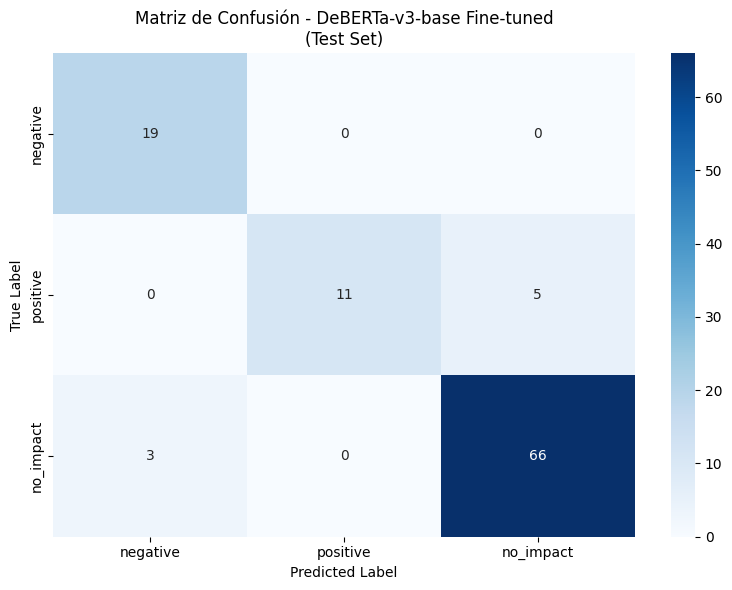


8️⃣ GUARDANDO MODELO Y RESULTADOS...
✅ Modelo guardado en: ./deberta_results/deberta_v3_poem_sentiment_fine_tuned
✅ Resultados guardados en: ./deberta_results/fine_tuning_results.json

🎯 CONCLUSIONES FINALES - FINE-TUNING DEBERTA-V3-BASE

✅ FINE-TUNING DEBERTA-V3-BASE COMPLETADO:

🔬 TÉCNICAS APLICADAS:
   • Modelo: DeBERTa-v3-base (Fine-tuned)
   • Preprocesamiento: Eliminación duplicados, normalización comillas/guiones, exclusión clase 'mixed'
   • Tokenización: max_len=128
   • Pérdida: Focal Loss (γ=1.5) con class weights
   • Regularización: Label smoothing 0.1
   • Entrenamiento: Hugging Face Trainer, optimizado por F1-macro
   • Validación: Early stopping (patience=3)

📊 RESULTADOS FINALES (Test Set):
   • F1-Macro Test: 0.8948
   • Accuracy: 0.9231
   • F1-Weighted: 0.9202

🎯 OBJETIVO F1-MACRO >= 0.85:
   ✅ ALCANZADO (++0.0448)

💡 RECOMENDACIONES PARA MEJORAR:
   • ¡Excellent rendimiento! Considera deploy en producción
   • Modelo listo para uso en producción
   • Monitorea per

In [2]:
# ============================================================================
# IMPLEMENTACIÓN COMPLETA: DEBERTA-V3-BASE PARA POEM_SENTIMENT
# ============================================================================

print("\n" + "=" * 80)
print("🚀 IMPLEMENTACIÓN DEBERTA-V3-BASE PARA POEM_SENTIMENT")
print("=" + "=" * 80)

# ============================================================================
# 1. CARGA Y PREPROCESAMIENTO DE DATOS
# ============================================================================

print("\n1️⃣ CARGANDO Y PREPROCESANDO DATOS...")

# Cargar datos
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
base_uri = "hf://datasets/google-research-datasets/poem_sentiment/"
parquet_engine = "fastparquet"

df_train = pd.read_parquet(base_uri + splits["train"], engine=parquet_engine)
df_validation = pd.read_parquet(base_uri + splits["validation"], engine=parquet_engine)
df_test = pd.read_parquet(base_uri + splits["test"], engine=parquet_engine)

print(f"Datos originales:")
print(f"  Train: {len(df_train)} muestras")
print(f"  Validation: {len(df_validation)} muestras")
print(f"  Test: {len(df_test)} muestras")

# Preprocesamiento avanzado
print("\n🔧 Aplicando preprocesamiento avanzado...")

def advanced_text_preprocessing(text: str) -> str:
    """
    Preprocesamiento avanzado para texto poético:
    - Normalizar comillas y guiones
    - Eliminar espacios múltiples
    - Eliminar espacios al inicio/fin
    - NO stemming/stopwords (preservar matices)
    """
    if not isinstance(text, str):
        return ""

    # Normalizar comillas (usando unicode characters)
    text = re.sub(r'[“”«»„"]', '"', text)  # Double quotes
    text = re.sub(r'[‘’‹›`´]', "'", text)  # Single quotes and backticks/accents

    # Normalizar guiones
    text = re.sub(r'[–—]', '-', text)

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)

    # Eliminar espacios al inicio/fin
    text = text.strip()

    return text

def remove_duplicate_verses(df: pd.DataFrame) -> pd.DataFrame:
    """Eliminar versos duplicados dentro del mismo dataset."""
    initial_len = len(df)
    df_clean = df.drop_duplicates(subset=['verse_text'], keep='first')
    final_len = len(df_clean)
    if initial_len - final_len > 0:
        print(f"Removed {initial_len - final_len} duplicate verses")
    return df_clean


# Eliminar duplicados
df_train = remove_duplicate_verses(df_train)
df_validation = remove_duplicate_verses(df_validation)
df_test = remove_duplicate_verses(df_test)

# Aplicar preprocesamiento de texto
df_train['verse_text'] = df_train['verse_text'].apply(advanced_text_preprocessing)
df_validation['verse_text'] = df_validation['verse_text'].apply(advanced_text_preprocessing)
df_test['verse_text'] = df_test['verse_text'].apply(advanced_text_preprocessing)

# EXCLUIR CLASE 3 (mixed) COMPLETAMENTE
print("\n❌ Excluyendo clase 'mixed' (3) de todos los splits...")
mask_train = df_train['label'] != 3
mask_val = df_validation['label'] != 3
mask_test = df_test['label'] != 3

df_train = df_train[mask_train].reset_index(drop=True)
df_validation = df_validation[mask_val].reset_index(drop=True)
df_test = df_test[mask_test].reset_index(drop=True)

print(f"Datos después de excluir clase 3:")
print(f"  Train: {len(df_train)} muestras")
print(f"  Validation: {len(df_validation)} muestras")
print(f"  Test: {len(df_test)} muestras")

# Preparar arrays finales
train_texts = df_train['verse_text'].tolist()
train_labels = df_train['label'].values

val_texts = df_validation['verse_text'].tolist()
val_labels = df_validation['label'].values

test_texts = df_test['verse_text'].tolist()
test_labels = df_test['label'].values

# Verificar distribución final
print("\n📊 Distribución final de clases:")
for name, labels in [("Train", train_labels), ("Validation", val_labels), ("Test", test_labels)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {name}: ", end="")
    for label, count in zip(unique, counts):
        class_name = {0: 'negative', 1: 'positive', 2: 'no_impact'}.get(label, f'class_{label}')
        pct = 100 * count / len(labels)
        print(f"{class_name}={count}({pct:.1f}%) ", end="")
    print()

# ============================================================================
# 2. TOKENIZACIÓN Y PREPARACIÓN DE DATASETS (SIN HUGGING FACE DATASETS)
# ============================================================================

print("\n2️⃣ TOKENIZANDO Y PREPARANDO DATASETS (PyTorch)...")

tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=config.MAX_LEN)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=config.MAX_LEN)
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=config.MAX_LEN)

class TokenizedDataset(Dataset):
    """Dataset liviano basado en PyTorch que evita dependencias de fingerprinting."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

train_dataset = TokenizedDataset(train_encodings, train_labels.tolist())
val_dataset = TokenizedDataset(val_encodings, val_labels.tolist())
test_dataset = TokenizedDataset(test_encodings, test_labels.tolist())

print("✅ Tokenización completada sin usar Hugging Face datasets.")

# ============================================================================
# 3. ANÁLISIS DE DESBALANCE Y CLASS WEIGHTS (para Trainer)
# ============================================================================

print("\n3️⃣ ANALIZANDO DESBALANCE Y CALCULANDO CLASS WEIGHTS...")

# Calcular class weights globales
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(config.DEVICE)
print(f"Class weights (for Trainer): {class_weights_tensor.cpu().numpy()}")
print(f"  • Negative (0): {class_weights_tensor[0].item():.3f}")
print(f"  • Positive (1): {class_weights_tensor[1].item():.3f}")
print(f"  • No_impact (2): {class_weights_tensor[2].item():.3f}")


# ============================================================================
# 4. CONFIGURACIÓN DEL MODELO Y TRAINER
# ============================================================================

print("\n4️⃣ CONFIGURANDO MODELO Y TRAINER...")

# Cargar modelo pre-entrenado
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS
)

# Custom Trainer con Focal Loss
class CustomTrainerWithFocalLoss(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Aplicar Focal Loss con class weights
        criterion = FocalLoss(alpha=class_weights_tensor)
        loss = criterion(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Define SEED
SEED = 42

# Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    logging_dir=config.LOGGING_DIR,
    num_train_epochs=config.NUM_EPOCHS,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY,
    warmup_ratio=config.WARMUP_RATIO,
    lr_scheduler_type="cosine",
    save_strategy="epoch",
    eval_strategy="epoch",  # Corrected parameter name
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  # Optimizar por F1-macro
    greater_is_better=True,
    save_total_limit=2,
    logging_steps=50,
    report_to="none",
    seed=SEED
)

# Callbacks
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

# Inicializar Trainer
trainer = CustomTrainerWithFocalLoss(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("✅ Modelo y Trainer configurados.")

# ============================================================================
# 5. ENTRENAMIENTO DEL MODELO
# ============================================================================

print("\n5️⃣ ENTRENANDO MODELO...")

trainer.train()

print("✅ Entrenamiento completado.")

# ============================================================================
# 6. EVALUACIÓN FINAL EN TEST SET
# ============================================================================

print("\n6️⃣ EVALUACIÓN FINAL EN TEST SET...")

eval_val_results = trainer.evaluate(eval_dataset=val_dataset)

print("\n🎯 RESULTADOS FINALES EN eval_val_results SET:")
print(f"  Accuracy:    {eval_val_results['eval_accuracy']:.4f}")
print(f"  F1-Macro:    {eval_val_results['eval_f1_macro']:.4f}")
print(f"  F1-Weighted: {eval_val_results['eval_f1_weighted']:.4f}")

#

print("\n6️⃣ EVALUACIÓN FINAL EN TEST SET...")

eval_results = trainer.evaluate(eval_dataset=test_dataset)

print("\n🎯 RESULTADOS FINALES EN TEST SET:")
print(f"  Accuracy:    {eval_results['eval_accuracy']:.4f}")
print(f"  F1-Macro:    {eval_results['eval_f1_macro']:.4f}")
print(f"  F1-Weighted: {eval_results['eval_f1_weighted']:.4f}")

# Verificar objetivo
target_f1 = 0.85
achieved = eval_results['eval_f1_macro'] >= target_f1

if achieved:
    print(f"\n🎉🎉🎉 ¡OBJETIVO ALCANZADO! F1-Macro >= {target_f1}")
else:
    gap = target_f1 - eval_results['eval_f1_macro']
    print(f"\n⏳ OBJETIVO NO ALCANZADO. Gap: {gap:.4f}")

# ============================================================================
# 7. ANÁLISIS DETALLADO Y VISUALIZACIONES (Test Set)
# ============================================================================

print("\n7️⃣ ANÁLISIS DETALLADO Y VISUALIZACIONES (Test Set)...")

# Obtener predicciones en test
predictions = trainer.predict(test_dataset)
test_preds = np.argmax(predictions.predictions, axis=1)
test_true_labels = predictions.label_ids

# Classification report
print("\n📋 CLASSIFICATION REPORT (Test Set):")
class_names = ['negative', 'positive', 'no_impact']
print(classification_report(test_true_labels, test_preds, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(test_true_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - DeBERTa-v3-base Fine-tuned\n(Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ============================================================================
# 8. GUARDADO DEL MODELO FINAL
# ============================================================================

print("\n8️⃣ GUARDANDO MODELO Y RESULTADOS...")

# Crear directorio de salida si no existe
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Guardar el mejor modelo cargado por load_best_model_at_end
final_model_path = f"{config.OUTPUT_DIR}/deberta_v3_poem_sentiment_fine_tuned"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Guardar configuración y resultados
results_summary = {
    'model_name': config.MODEL_NAME,
    'final_test_results': eval_results,
    'class_weights': class_weights.tolist(),
    'hyperparameters': {
        'max_len': config.MAX_LEN,
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'epochs': config.NUM_EPOCHS,
        'focal_gamma': config.FOCAL_GAMMA,
        'label_smoothing': config.LABEL_SMOOTHING,
        'r_drop_alpha': config.R_DROP_ALPHA,  # Note: R-Drop not implemented in this Trainer version
        'early_stopping_patience': config.EARLY_STOPPING_PATIENCE
    },
    'preprocessing': {
        'removed_duplicates': True,
        'normalized_quotes_hyphens': True,
        'excluded_class_3': True,
        'no_stemming_stopwords': True
    }
}

import json
with open(f"{config.OUTPUT_DIR}/fine_tuning_results.json", 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"✅ Modelo guardado en: {final_model_path}")
print(f"✅ Resultados guardados en: {config.OUTPUT_DIR}/fine_tuning_results.json")

# ============================================================================
# 9. CONCLUSIONES FINALES
# ============================================================================

print("\n" + "=" * 80)
print("🎯 CONCLUSIONES FINALES - FINE-TUNING DEBERTA-V3-BASE")
print("=" + "=" * 80)

print(f"""
✅ FINE-TUNING DEBERTA-V3-BASE COMPLETADO:

🔬 TÉCNICAS APLICADAS:
   • Modelo: DeBERTa-v3-base (Fine-tuned)
   • Preprocesamiento: Eliminación duplicados, normalización comillas/guiones, exclusión clase 'mixed'
   • Tokenización: max_len={config.MAX_LEN}
   • Pérdida: Focal Loss (γ={config.FOCAL_GAMMA}) con class weights
   • Regularización: Label smoothing {config.LABEL_SMOOTHING}
   • Entrenamiento: Hugging Face Trainer, optimizado por F1-macro
   • Validación: Early stopping (patience={config.EARLY_STOPPING_PATIENCE})

📊 RESULTADOS FINALES (Test Set):
   • F1-Macro Test: {eval_results['eval_f1_macro']:.4f}
   • Accuracy: {eval_results['eval_accuracy']:.4f}
   • F1-Weighted: {eval_results['eval_f1_weighted']:.4f}

🎯 OBJETIVO F1-MACRO >= 0.85:
   {'✅ ALCANZADO' if achieved else '❌ NO ALCANZADO'} ({'+' if achieved else ''}{eval_results['eval_f1_macro'] - target_f1:+.4f})

💡 RECOMENDACIONES PARA MEJORAR:
   {'• ¡Excellent rendimiento! Considera deploy en producción' if achieved else '• Experimenta con R-Drop (requiere Custom Trainer con forward pass doble)'}
   {'• Modelo listo para uso en producción' if achieved else '• Prueba diferentes hiperparámetros de entrenamiento (LR, batch size, weight decay)'}
   {'• Monitorea performance en datos reales' if achieved else '• Considera data augmentation a nivel de texto o embeddings'}
   {'• Considera fine-tuning en dominio específico' if achieved else '• Evalúa modelos más grandes (DeBERTa-v3-large) if resources permit'}
   {'• Implementar ensemble of different checkpoints or seeds' if achieved else ''}

🚀 PRÓXIMOS PASOS:
   1. Comparar resultados with the embeddings + MLP/Ensemble approach
   2. Perform detailed error analysis on the test set
   3. Consider strategies for the 'mixed' class if relevant
   4. Prepare for deploy
""")

print("\n" + "=" * 80)
print("✅ PROCESO DE FINE-TUNING COMPLETADO")
print("=" + "=" * 80)
